In [1]:
import numpy as np
import mdp
from ct_ucrl import ct_ucrl, extended_value_iteration
import matplotlib.pyplot as plt
import tqdm
import pickle as pkl
%load_ext autoreload
%autoreload 2

# Test of CT_MDP

In [2]:
n_states = n_actions = 2
p = np.array([[[0, 1],[0, 1]],
     [[1, 0],[1, 0]]])
r = np.array([[5, 8], [-4, -12]])
holding_lambda = np.array([[3, 5], [2, 7]])
ct_mdp = mdp.CTMDP(2, 2, p, r, holding_lambda)
holding_time_record = {0: {0: [], 1:[]}, 1: {0: [], 1:[]}}
transit_record = {0: {0: np.array([0, 0]), 1:np.array([0, 0])}, 
                  1: {0: np.array([0, 0]), 1:np.array([0, 0])}}

In [3]:
print(ct_mdp.reset(0))
for i in range(50000):
    ac = np.random.randint(2)
    state = ct_mdp.state
    next_state, reward, holding_time = ct_mdp.step(ac)
    holding_time_record[state][ac].append(holding_time)
    transit_record[state][ac][next_state] += 1

0


In [4]:
for state in [0, 1]:
    for action in [0, 1]:
        print(state, action, 1/np.mean(holding_time_record[state][action]))
        print(transit_record[state][action]/np.sum(transit_record[state][action]))

0 0 2.9814391424827824
[0. 1.]
0 1 4.968391863818351
[0. 1.]
1 0 1.975952795051689
[1. 0.]
1 1 6.976536786962331
[1. 0.]


# Test of CT_UCRL

In [5]:
eps = 1e-4
n_actions = 2

# Two-state example
# n_states = 2
# p = np.array([[[0, 1],[0, 1]],
#      [[1, 0],[1, 0]]])
# r = np.array([[5, 8], [-4, -12]])
# holding_lambda = np.array([[3, 5], [2, 7]])

# Three-state example
n_states = 3
p = np.array([[[0, 1/2, 1/2], [0, 1/3, 2/3]],
              [[2/3, 0, 1/3], [1/4, 0, 3/4]],
              [[1/2, 1/2, 0], [3/5, 2/5, 0]]])
r = np.array([[5, 8], [5, 2], [4, 10]])/10
holding_lambda = np.array([[5, 2], [2, 1], [7, 3]])

## Optimal Value Function

In [6]:
state_val, best_ac, best_mdp = extended_value_iteration(
    n_states, n_actions, np.array(r), np.array(p), np.zeros(np.shape(p)[:2]), 
    1 / np.array(holding_lambda), np.zeros(np.shape(holding_lambda)), 
    holding_lambda.min(), holding_lambda.max(), eps)
st = 1
ac = best_ac[st]
rho_star = ((p[st][ac] * state_val).sum() - state_val[st] + r[st, ac]) * holding_lambda[st, ac]
rho_star

1.9447693153508698

## CT-UCRL

In [10]:
opt_tr = {}
num_dec_epoch = int(2e7)
num_sim = 1
opt_regret = {}
for sim in range(num_sim):
    print(sim, end='\r')
    opt_tr[sim] = []
    opt_regret[sim] = []
    ct_mdp = mdp.CTMDP(n_states, n_actions, p, r, holding_lambda)

    transitions = ct_ucrl(ct_mdp, np.max(holding_lambda), np.min(holding_lambda), 
                        r, 0.005, 0)
    sum_reward = 0

    for _ in tqdm.tqdm(range(num_dec_epoch)):
        (t, st, ac, next_st, holding_time, reward) = transitions.__next__()
        opt_tr[sim].append((t, st, ac, next_st, holding_time, reward))
        sum_reward += reward
        opt_regret[sim].append((rho_star * ct_mdp.timer - sum_reward,
                                rho_star * ct_mdp.timer, sum_reward))

  0%|          | 0/20000000 [00:00<?, ?it/s]

100%|██████████| 20000000/20000000 [13:28<00:00, 24736.33it/s]


In [11]:
np_opt_regret = np.array([opt_regret[sim] for sim in range(num_sim)])
np_opt_regret

array([[[-7.19782072e+00,  8.02179282e-01,  8.00000000e+00],
        [-8.10871883e-02,  3.91891281e+00,  4.00000000e+00],
        [-7.35365646e+00,  4.64634354e+00,  1.20000000e+01],
        ...,
        [ 6.09382490e+03,  4.00030178e+07,  3.99969240e+07],
        [ 6.08720867e+03,  4.00030192e+07,  3.99969320e+07],
        [ 6.09187685e+03,  4.00030199e+07,  3.99969280e+07]]])

Text(0, 0.5, 'Regret')

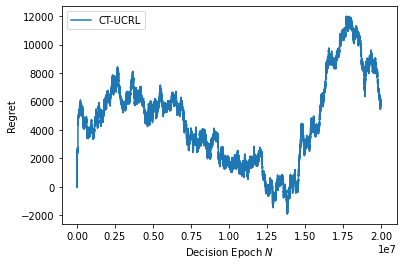

In [13]:
log_factor = 8000
label_gap = 5
xlabel = [k * label_gap for k in range(1, num_dec_epoch // label_gap + 1)]
plt.plot(xlabel, np_opt_regret.mean(axis=0)[::label_gap, 0], 
         label = 'CT-UCRL')
# plt.plot(xlabel, log_factor * np.log(xlabel), 
#          label=r'${}\log(N)$'.format(log_factor))
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.legend()
plt.xlabel(r'Decision Epoch $N$')
plt.ylabel('Regret')
# plt.savefig('../../fig/CT-UCRL/EX2/one_path1', bbox_inches='tight', dpi=300)

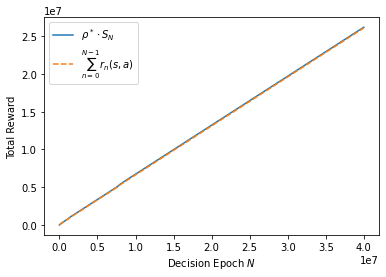

In [138]:
label_gap = 5
xlabel = [k * label_gap for k in range(1, num_dec_epoch // label_gap + 1)]
plt.plot(xlabel, np_opt_regret.mean(axis=0)[::label_gap, 1], 
         label = r'$\rho^* \cdot S_N$')
plt.plot(xlabel, np_opt_regret.mean(axis=0)[::label_gap, 2], 
         label = r'$\sum_{n=0}^{N - 1} r_n(s,a)$', linestyle='--')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.legend()
plt.xlabel(r'Decision Epoch $N$')
plt.ylabel('Total Reward')
# plt.savefig('../../fig/CT-UCRL/EX2/total_reward1', bbox_inches='tight', dpi=300)

# Sub-optimal Policy

In [108]:
num_dec_epoch = 2000000
ct_mdp = mdp.CTMDP(n_states, n_actions, p, r, holding_lambda)
st = ct_mdp.reset(0)
sub_policy = np.array([0, 0])
sub_tr = []
sub_regret = []
sum_reward = 0
for n in range(num_dec_epoch):
    next_st, reward, holding_time = ct_mdp.step(ac)
    # print('step', t, st, ac, next_st, reward)
    # Update statistics

    st = next_st
    ac = sub_policy[st]
    sub_tr.append((n, ct_mdp.timer, st, ac, next_st, reward))
    sum_reward += reward
    sub_regret.append((rho_star * ct_mdp.timer - sum_reward, 
                       rho_star * ct_mdp.timer, sum_reward))

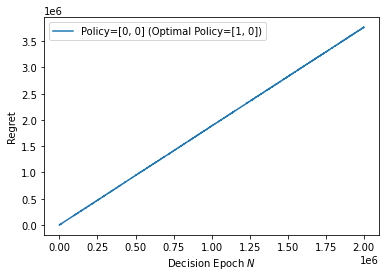

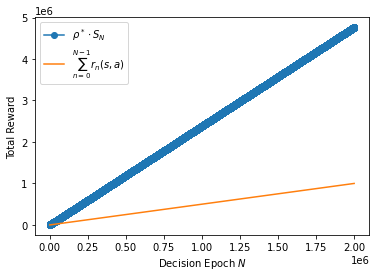

In [111]:
np_sub_regret = np.array(sub_regret)
plt.plot(np_sub_regret[:, 0], label='Policy=[0, 0] (Optimal Policy=[1, 0])')
plt.legend()
plt.xlabel(r'Decision Epoch $N$')
plt.ylabel('Regret')
plt.show()

plt.plot(np_sub_regret[:, 1], label = r'$\rho^* \cdot S_N$', marker='o')
plt.plot(np_sub_regret[:, 2], label = r'$\sum_{n=0}^{N - 1} r_n(s,a)$')
plt.xlabel(r'Decision Epoch $N$')
plt.ylabel('Total Reward')
plt.legend()
plt.show()

In [89]:
np_sub_tr = np.array(sub_tr)
sub_rho = np_sub_tr[:, -1].sum() / ct_mdp.timer
sub_rho
sub_gap = rho_star - sub_rho
sub_gap

-0.0037547802613753234

In [52]:
bound_const = 34**2 * holding_lambda.max() * 4 * 2 
print(bound_const)
bound_const += 2 * 73**2 * (holding_lambda.max() / holding_lambda.min())**2 * 2 * 2
print(bound_const)
bound_const += 24 * 2 * 2 / (holding_lambda.min()**2)
print(bound_const) 
bound_const *= 3
print(bound_const)

64736
586978.0
587002.0
1761006.0


In [7]:
num_dec_epoch = int(1e7)
num_sim = 50
avg_regret = [0, np.zeros(num_dec_epoch)]
# avg_reward = [0, np.zeros(num_dec_epoch)]
# avg_rhoT = [0, np.zeros(num_dec_epoch)]

  0%|          | 687/10000000 [00:00<24:18, 6856.62it/s]

100%|██████████| 10000000/10000000 [06:17<00:00, 26513.75it/s]


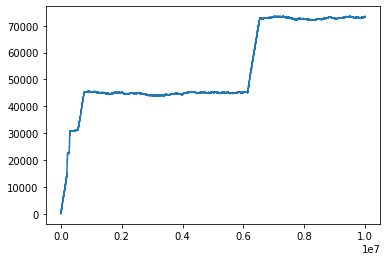

100%|██████████| 10000000/10000000 [05:59<00:00, 27829.21it/s]


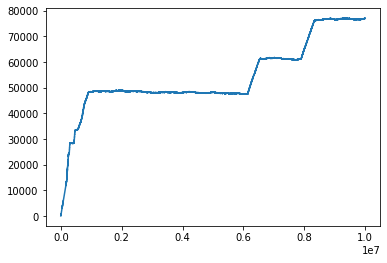

100%|██████████| 10000000/10000000 [05:54<00:00, 28212.12it/s]


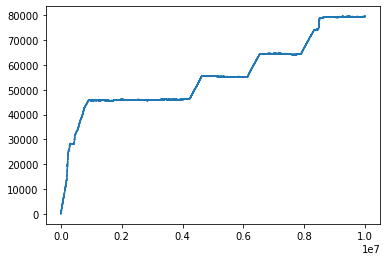

100%|██████████| 10000000/10000000 [05:56<00:00, 28043.44it/s]


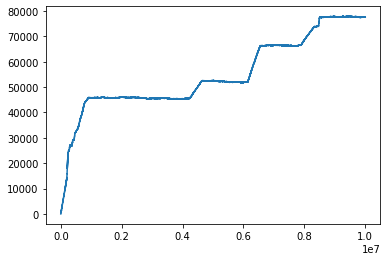

100%|██████████| 10000000/10000000 [06:11<00:00, 26925.66it/s]


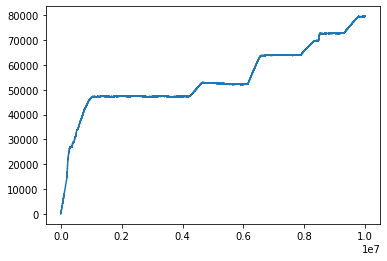

100%|██████████| 10000000/10000000 [06:12<00:00, 26849.54it/s]


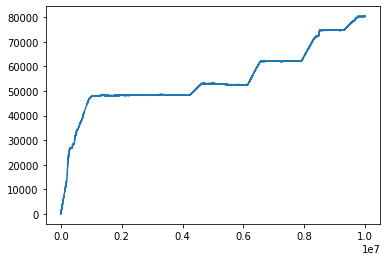

100%|██████████| 10000000/10000000 [06:16<00:00, 26591.36it/s]


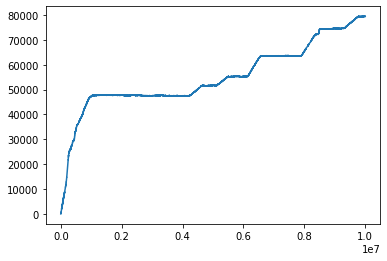

100%|██████████| 10000000/10000000 [06:11<00:00, 26884.57it/s]


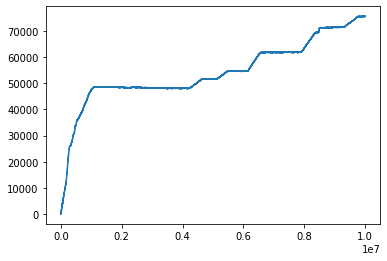

100%|██████████| 10000000/10000000 [06:09<00:00, 27049.01it/s]


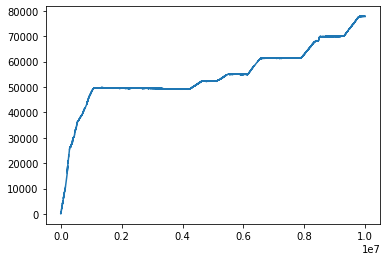

100%|██████████| 10000000/10000000 [06:06<00:00, 27318.88it/s]


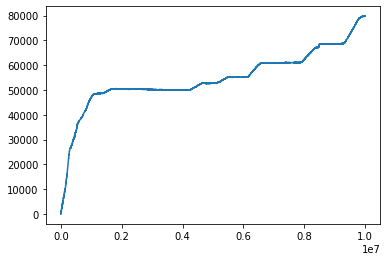

100%|██████████| 10000000/10000000 [05:54<00:00, 28217.54it/s]


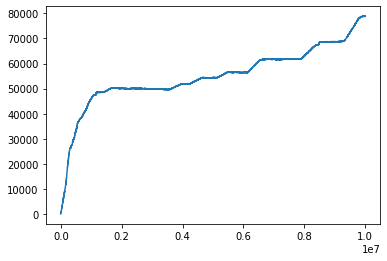

100%|██████████| 10000000/10000000 [05:50<00:00, 28511.20it/s]


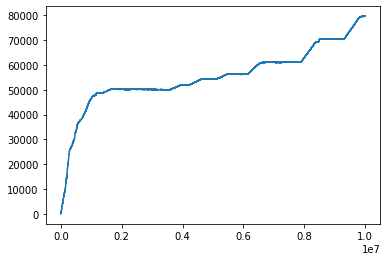

100%|██████████| 10000000/10000000 [05:52<00:00, 28375.23it/s]


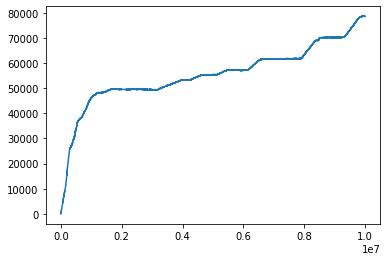

100%|██████████| 10000000/10000000 [05:49<00:00, 28599.34it/s]


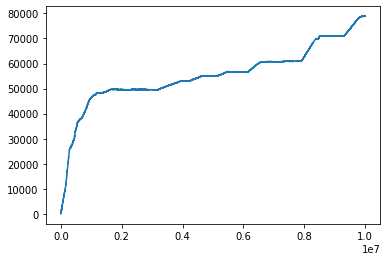

100%|██████████| 10000000/10000000 [06:28<00:00, 25759.06it/s]


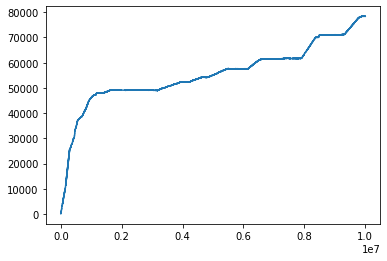

100%|██████████| 10000000/10000000 [06:04<00:00, 27425.52it/s]


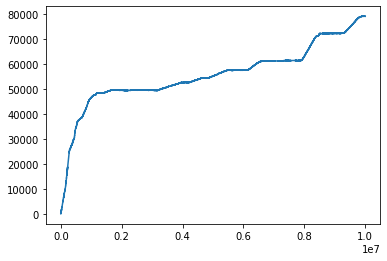

100%|██████████| 10000000/10000000 [06:09<00:00, 27089.66it/s]


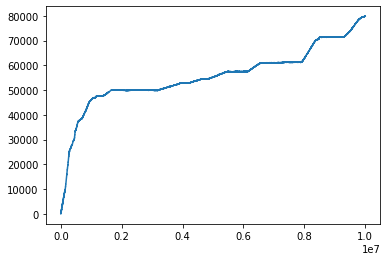

100%|██████████| 10000000/10000000 [06:05<00:00, 27386.45it/s]


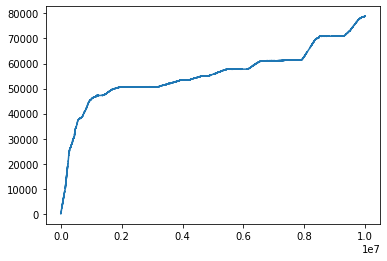

100%|██████████| 10000000/10000000 [05:52<00:00, 28393.17it/s]


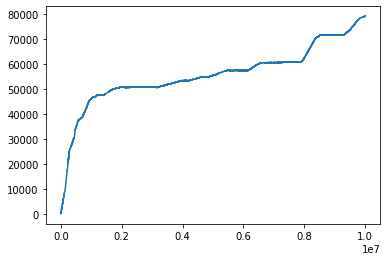

100%|██████████| 10000000/10000000 [06:03<00:00, 27531.97it/s]


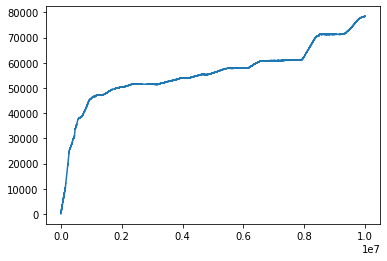

100%|██████████| 10000000/10000000 [06:26<00:00, 25903.53it/s]


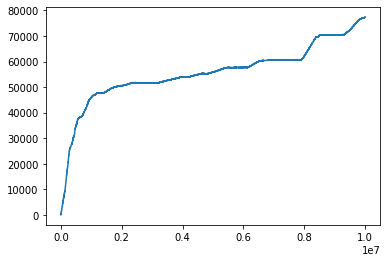

100%|██████████| 10000000/10000000 [06:11<00:00, 26897.78it/s]


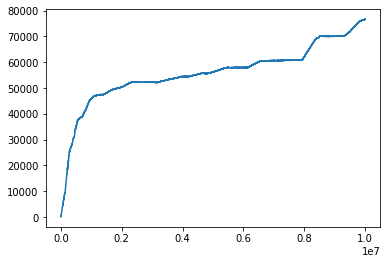

100%|██████████| 10000000/10000000 [05:52<00:00, 28395.49it/s]


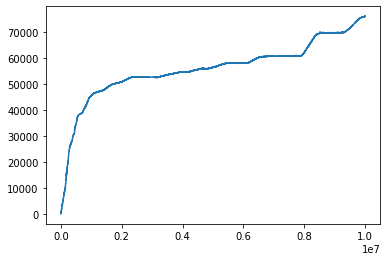

100%|██████████| 10000000/10000000 [06:04<00:00, 27434.67it/s]


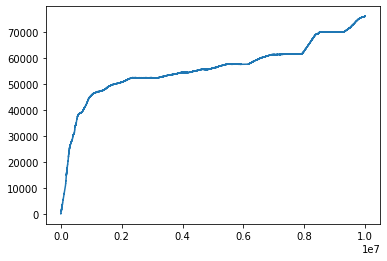

100%|██████████| 10000000/10000000 [06:04<00:00, 27461.11it/s]


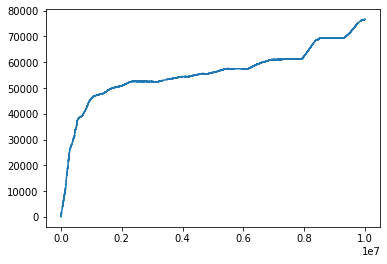

100%|██████████| 10000000/10000000 [06:18<00:00, 26452.65it/s]


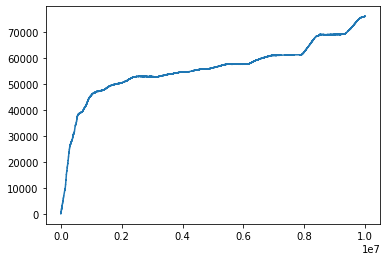

100%|██████████| 10000000/10000000 [06:22<00:00, 26175.97it/s]


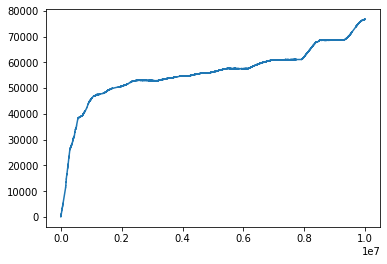

100%|██████████| 10000000/10000000 [06:05<00:00, 27339.38it/s]


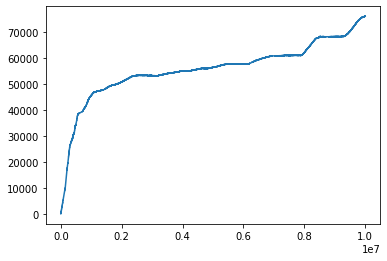

100%|██████████| 10000000/10000000 [06:00<00:00, 27770.58it/s]


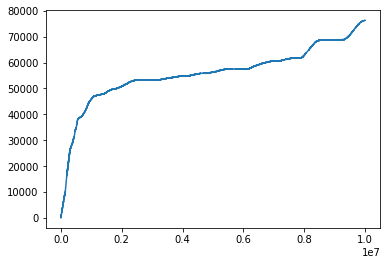

100%|██████████| 10000000/10000000 [06:00<00:00, 27745.01it/s]


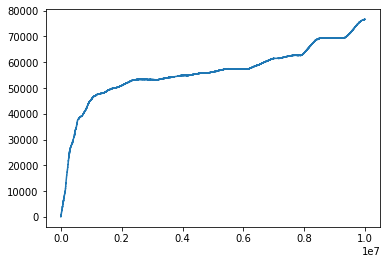

100%|██████████| 10000000/10000000 [06:07<00:00, 27241.85it/s]


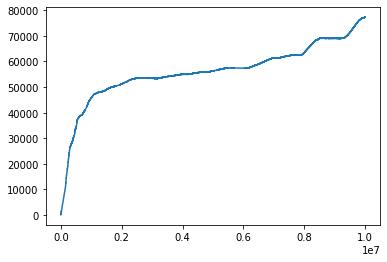

100%|██████████| 10000000/10000000 [06:15<00:00, 26621.48it/s]


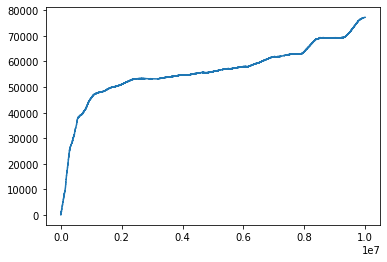

100%|██████████| 10000000/10000000 [06:35<00:00, 25288.18it/s]


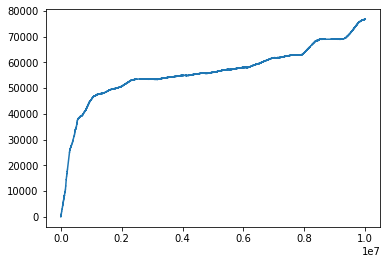

100%|██████████| 10000000/10000000 [06:27<00:00, 25802.61it/s]


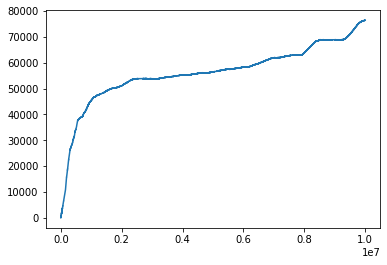

100%|██████████| 10000000/10000000 [06:30<00:00, 25619.38it/s]


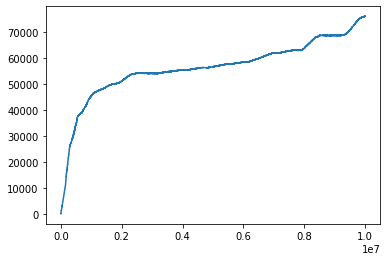

100%|██████████| 10000000/10000000 [06:29<00:00, 25647.63it/s]


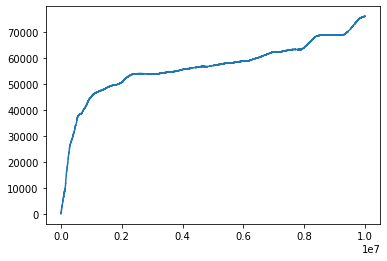

100%|██████████| 10000000/10000000 [06:19<00:00, 26378.31it/s]


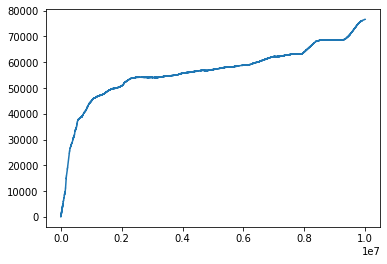

100%|██████████| 10000000/10000000 [06:20<00:00, 26314.88it/s]


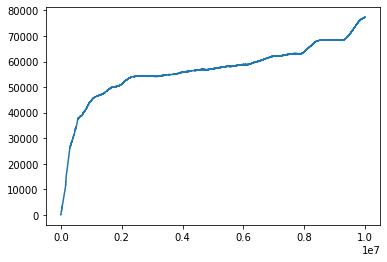

100%|██████████| 10000000/10000000 [06:20<00:00, 26282.22it/s]


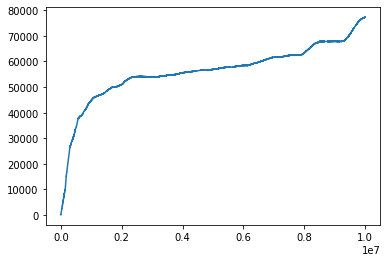

100%|██████████| 10000000/10000000 [06:21<00:00, 26242.17it/s]


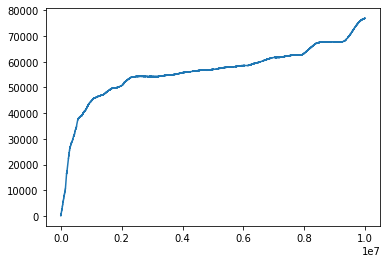

100%|██████████| 10000000/10000000 [06:19<00:00, 26345.37it/s]


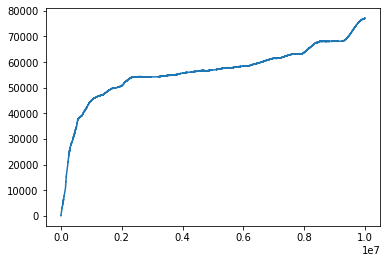

100%|██████████| 10000000/10000000 [06:24<00:00, 25979.62it/s]


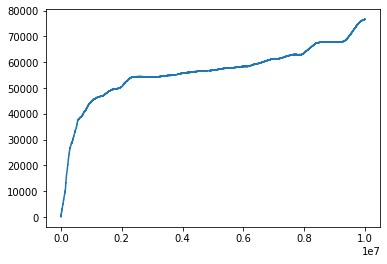

100%|██████████| 10000000/10000000 [06:23<00:00, 26077.82it/s]


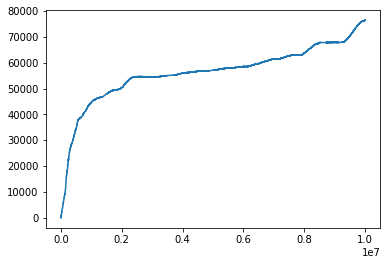

100%|██████████| 10000000/10000000 [06:19<00:00, 26324.14it/s]


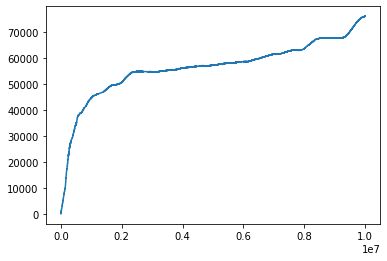

100%|██████████| 10000000/10000000 [06:20<00:00, 26253.59it/s]


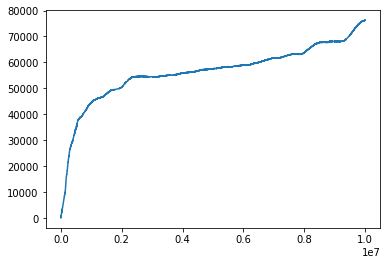

100%|██████████| 10000000/10000000 [06:20<00:00, 26314.03it/s]


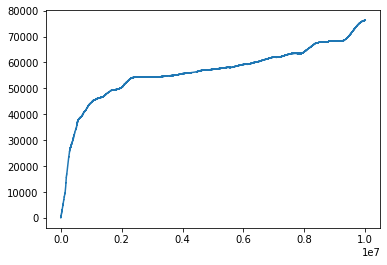

100%|██████████| 10000000/10000000 [05:52<00:00, 28367.31it/s]


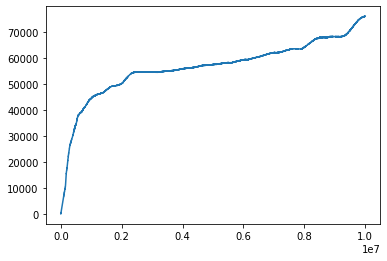

100%|██████████| 10000000/10000000 [05:50<00:00, 28538.81it/s]


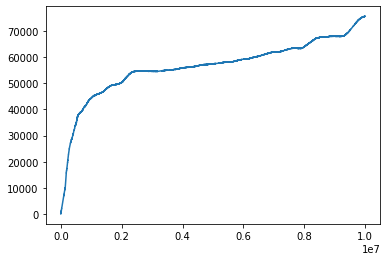

100%|██████████| 10000000/10000000 [05:50<00:00, 28534.99it/s]


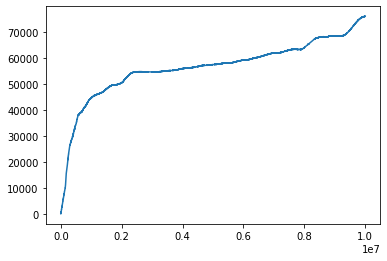

100%|██████████| 10000000/10000000 [06:03<00:00, 27512.47it/s]


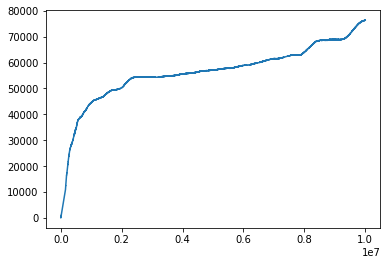

In [8]:
num_sim = 50
for sim in range(num_sim):
    print(sim, end='\r')
    opt_regret = []
    ct_mdp = mdp.CTMDP(n_states, n_actions, p, r, holding_lambda)

    transitions = ct_ucrl(ct_mdp, np.max(holding_lambda), np.min(holding_lambda), 
                        r, 0.01, 0)
    sum_reward = 0

    for _ in tqdm.tqdm(range(num_dec_epoch)):
        (t, st, ac, next_st, holding_time, reward) = transitions.__next__()
#         opt_tr[sim].append((t, st, ac, next_st, holding_time, reward))
        sum_reward += reward
        opt_regret.append((rho_star * ct_mdp.timer - sum_reward,
                           rho_star * ct_mdp.timer, sum_reward))
    
    opt_regret = np.array(opt_regret)
    
    avg_regret[0] = sim + 1
    avg_regret[1] = (avg_regret[1] * sim + opt_regret[:, 0]) / (sim + 1)
#     avg_rhoT[1] = (avg_rhoT[1] * sim + opt_regret[:, 1]) / (sim + 1)
#     avg_reward[1] = (avg_reward[1] * sim + opt_regret[:, 2]) / (sim + 1)
#     opt_regret = np.array(opt_regret)
        
    with open('../../data/CT-UCRL/EX1/delta_001/regret_sim' + str(sim), 'wb') as file:
        pkl.dump(opt_regret, file)
        file.close()
#     avg_regret[0] = sim + 1
#     avg_regret[1] = (avg_regret[1] * sim + np.array(opt_regret)) / (sim + 1)

    
        
#     with open('../../data/CT-UCRL/EX2/delta_001/regret', 'wb') as file:
#         pkl.dump(avg_regret, file)
#         file.close()
#     with open('../../data/CT-UCRL/EX2/delta_001/reward', 'wb') as file:
#         pkl.dump(avg_reward, file)
#         file.close()
#     with open('../../data/CT-UCRL/EX2/delta_001/rhoT', 'wb') as file:
#         pkl.dump(avg_rhoT, file)
#         file.close()
    plt.plot(avg_regret[1], label = 'CT-UCRL')
    plt.show()

In [11]:
avg_regret = pkl.load(open('../../data/CT-UCRL/EX1/delta_00005/regret', 'rb'))

Text(0, 0.5, 'Regret')

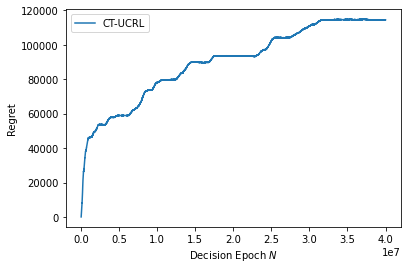

In [12]:
log_factor = 8000
label_gap = 5
xlabel = [k * label_gap for k in range(1, num_dec_epoch // label_gap + 1)]
plt.plot(xlabel, avg_regret[1][::label_gap], 
         label = 'CT-UCRL')
# plt.plot(xlabel, log_factor * np.log(xlabel), 
#          label=r'${}\log(N)$'.format(log_factor))
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.legend()
plt.xlabel(r'Decision Epoch $N$')
plt.ylabel('Regret')
# plt.savefig('../../fig/CT-UCRL/EX2/one_path1', bbox_inches='tight', dpi=300)